In [1]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
with open("names.txt", 'r') as file:
    words = file.read().splitlines()

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {char: i + 1 for i, char in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

In [5]:
vocab_size = len(itos)
block_size = 3

for word in words[:5]:
    print(word)
    context = [0] * block_size
    for char in word + '.':
        ix = stoi[char]
        print(''.join(itos[c] for c in context), '--->', itos[ix])
        context = context[1:] + [ix]
        

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [6]:
vocab_size = len(itos)
block_size = 3
def build_dataset(words):
    X, Y  = [], []
    for w in words:
        context = [0] * block_size
        for char in w + ".":
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1: n2])
Xte, Yte = build_dataset(words[n2:]) 

torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [73]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn(vocab_size, n_embd)
# use gain for std (tanh), want to decrease the range between values
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
#give some entropy
#b1 = torch.randn((n_hidden, ), generator=g) * 0.01
#to squeeze weights after tanh (-1, 1)
W2 = torch.randn((n_hidden,     vocab_size), generator=g) * 0.01
#initialize to zero
b2 = torch.randn((vocab_size, ), generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
    
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

12097


In [8]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1, its constant for batch in neuron, neutralize mean (x@w + b1) - (mean(x@w) + b1)
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi =  hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) #if h is close (-1, 1) then neurons do not learn from grad
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward() 
    
    lr = 0.1 if i < 1000_000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): 4f}')    
    lossi.append(loss.log10().item())
loss.item()

      0/ 200000:  3.314528
  10000/ 200000:  2.141546
  20000/ 200000:  2.548684
  30000/ 200000:  2.046500
  40000/ 200000:  1.923382
  50000/ 200000:  2.001173
  60000/ 200000:  2.233931
  70000/ 200000:  2.260029
  80000/ 200000:  2.532061
  90000/ 200000:  2.156819
 100000/ 200000:  1.893832
 110000/ 200000:  2.137511
 120000/ 200000:  2.141471
 130000/ 200000:  1.918683
 140000/ 200000:  2.414561
 150000/ 200000:  1.748861
 160000/ 200000:  1.874008
 170000/ 200000:  2.391768
 180000/ 200000:  2.381217
 190000/ 200000:  2.001561


1.8427159786224365

In [10]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'valid': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) #if h is close (-1, 1) then neurons do not learn from grad
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('valid')

train 2.0780162811279297
valid 2.38143253326416


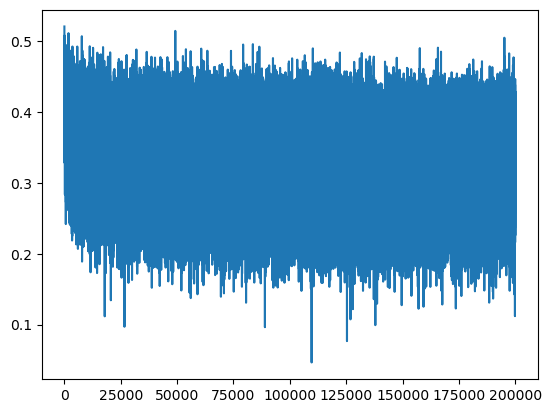

In [ ]:
plt.plot(lossi)
plt.show()

In [ ]:
g = torch.Generator().manual_seed(2147483647)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(
            emb.view(emb.shape[0], -1) @ W1 + b1
        )
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[o] for o in out))

teramaciaacueaapgantyhkh.
mnbsienammrl.
fda.
mhn.
rarkaichbljeteryiltfigmczi.
synxuraapbrdaakkauolm.
sidelhnk.
vgvnfrlsbs.
mhr.
nngaataakhhr.
nsiraaangolhr.
nsyiranxnfrldaiceeakmnceruaagket.
gaiksiephdb.
vsye.
muyelhzl.
nmrblhaabhdeeeeanmsiekilmri.
vmuser.
mysoi.
rapteapbrlegakkhrcieeaakhaietanghmnb.
mrinqsam.


In [106]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn((fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, X):
        self.out = X @ self.W
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.W] if self.bias is None else [self.W, self.bias]
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, monumentum=0.1):
        self.eps = eps
        self.monumentum = monumentum
        self.training=True
        #params
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        #buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, X):
        if self.training:
            xmean = X.mean(0, keepdim=True)
            xvar = X.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        
        self.out = self.gamma * (X - xmean) / torch.sqrt(xvar + self.eps) + self.beta
        
        with torch.no_grad():
            self.running_mean = (1-self.monumentum)*self.running_mean + self.monumentum * xmean
            self.running_var = (1-self.monumentum)*self.running_var + self.monumentum * xvar
            
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]
with torch.no_grad():
    layers[-1].W *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3
        
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [107]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]
with torch.no_grad():
    #layers[-1].W *= 0.1
    layers[-1].gamma *= 0.1
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.W *= 5/3
        
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [108]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, len(Xtr), (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    for layer in layers:
        layer.out.retain_grad()
        
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 1000_000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad      
    
    if i % 10_000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item(): 4f}')    
    lossi.append(loss.log10().item())
    
    if i >= 1000:
        break
loss.item()

      0/ 200000:  3.316278


2.0785109996795654

layer 2 (      Tanh): mean -0.01 std 0.63, saturated: 2.81%
layer 5 (      Tanh): mean +0.00 std 0.64, saturated: 2.66%
layer 8 (      Tanh): mean -0.00 std 0.64, saturated: 2.53%
layer 11 (      Tanh): mean -0.01 std 0.64, saturated: 2.31%
layer 14 (      Tanh): mean +0.00 std 0.64, saturated: 2.03%


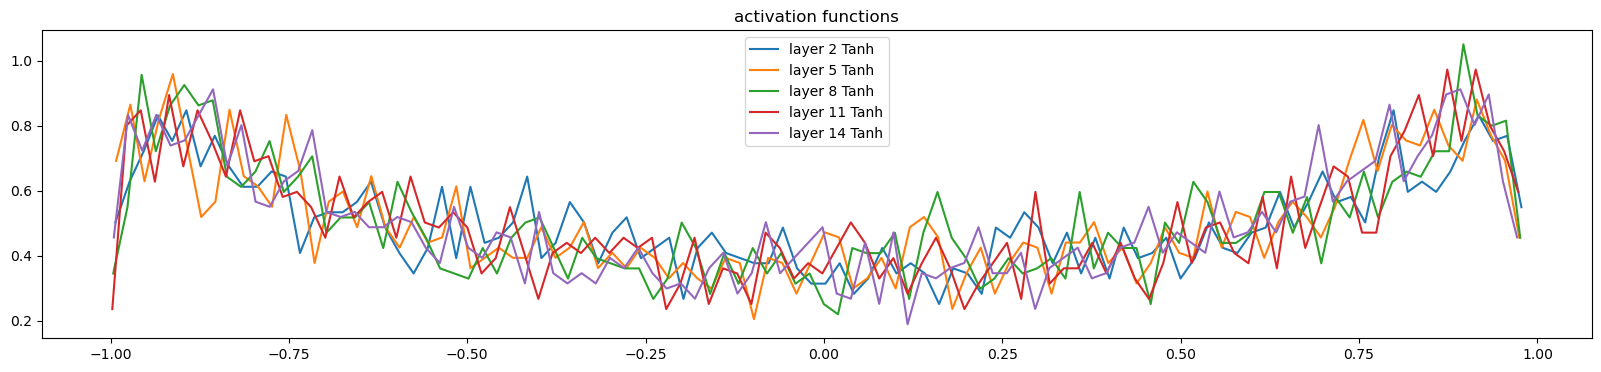

In [109]:
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {layer.__class__.__name__}')

#plt.ylim([0, 4.0])
plt.legend(legends)
plt.title('activation functions')
plt.show()

layer 2 (      Tanh): mean +0.000000, std 3.825863e-03
layer 5 (      Tanh): mean -0.000000, std 3.166240e-03
layer 8 (      Tanh): mean -0.000000, std 2.912048e-03
layer 11 (      Tanh): mean -0.000000, std 2.602258e-03
layer 14 (      Tanh): mean -0.000000, std 2.558130e-03


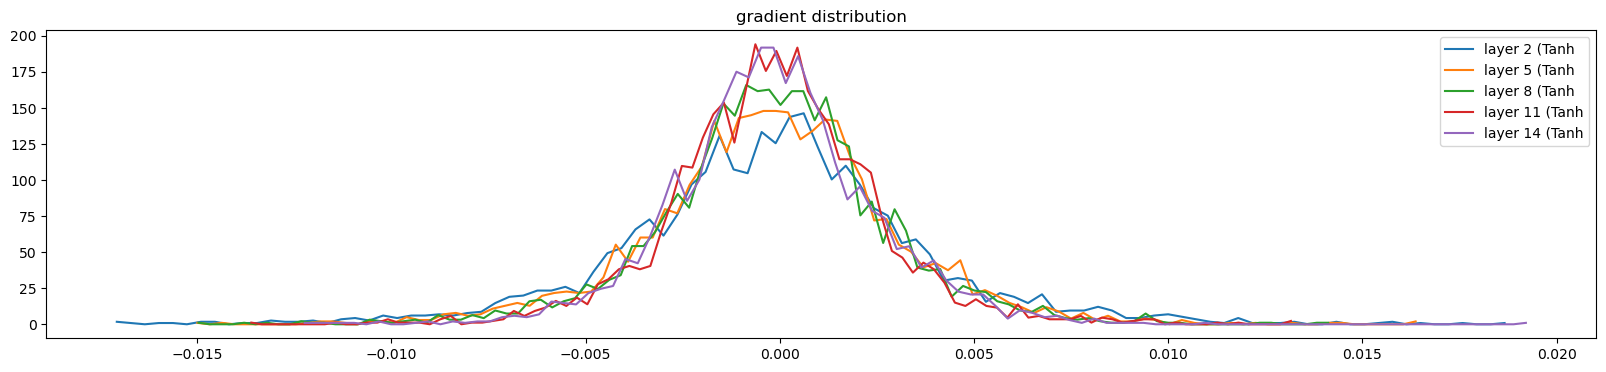

In [110]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')
plt.show()

weight   (27, 10) | mean -0.000000 | std 9.910910e-03 | grad:data ratio 9.900860e-03
weight  (30, 100) | mean +0.000280 | std 9.272929e-03 | grad:data ratio 2.966826e-02
weight (100, 100) | mean -0.000065 | std 7.534114e-03 | grad:data ratio 4.507332e-02
weight (100, 100) | mean -0.000017 | std 6.559602e-03 | grad:data ratio 3.889574e-02
weight (100, 100) | mean -0.000010 | std 5.577375e-03 | grad:data ratio 3.322899e-02
weight (100, 100) | mean -0.000040 | std 5.505680e-03 | grad:data ratio 3.278779e-02
weight  (100, 27) | mean +0.000005 | std 1.091376e-02 | grad:data ratio 6.545662e-02


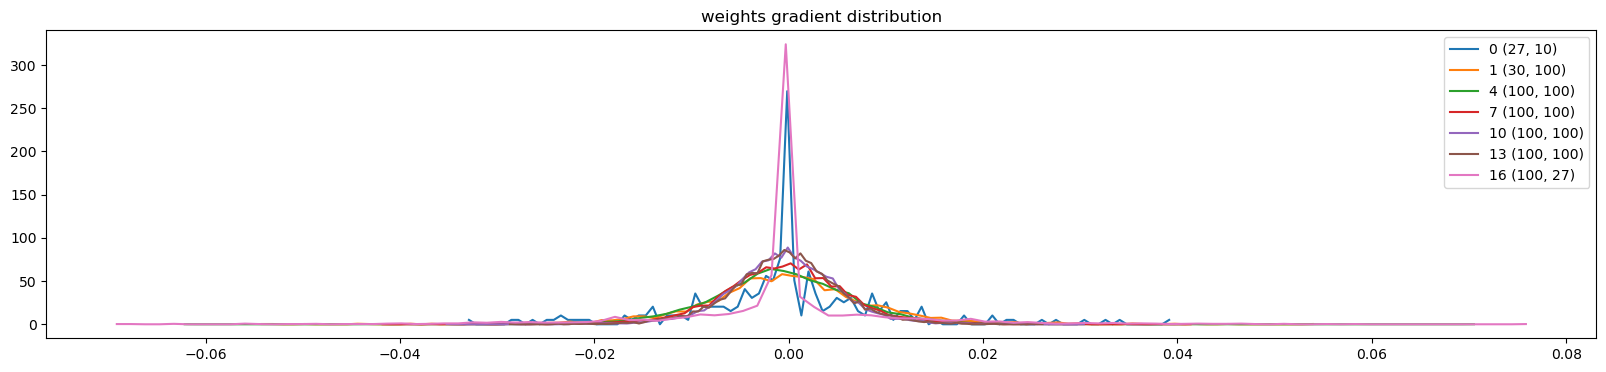

In [111]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')
plt.show()